# Analyzing Yelp Business Intelligence Data
***
Daniel Harrington  
Project 2  
April 14, 2022  
CIS 9760  
***

## Part I: Installation and Initial Setup
***

In [1]:
sc.install_pypi_package("pandas==1.0.3")
sc.install_pypi_package("matplotlib==3.2.1")

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1651258864369_0001,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.functions import *

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Loading Datasets from S3
***

In [3]:
business = spark.read.json('s3://harringtondaniel/yelpReviews/yelp_academic_dataset_business.json')
review = spark.read.json('s3://harringtondaniel/yelpReviews/yelp_academic_dataset_review.json')
user = spark.read.json('s3://harringtondaniel/yelpReviews/yelp_academic_dataset_user.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### First Five Rows of the Business Dataset
***

In [4]:
business.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|             address|          attributes|         business_id|          categories|         city|               hours|is_open|  latitude|   longitude|                name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|1616 Chapala St, ...|[,,,,,,,,,,, True...|Pns2l4eNsfO8kk83d...|Doctors, Traditio...|Santa Barbara|                null|      0|34.4266787|-119.7111968|Abby Rappoport, L...|      93101|           7|  5.0|   CA|
|87 Grasso Plaza S...|[,,,,,,,,, True,,...|mpf3x-BjTdTEA3yCZ...|Shipping Centers,...|       Affton|[8:0-18:30, 0:0-0...|      1| 38.551126|  -90.335695|    

### Overview of Data
***

In [5]:
length = str(len(business.columns))
row_count = str(business.count())
print("The number of columns in the Business table is: " + length) 
print("The number of rows in the Business table is: " + row_count)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

The number of columns in the Business table is: 14
The number of rows in the Business table is: 150346

#### Display DataFrame Schema
***

In [6]:
business.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

#### First Five Rows from Specific Columns
***

In [7]:
overview_five = business.select("business_id", "name", "city", "state", "categories")
overview_five.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+-------------+-----+--------------------+
|         business_id|                name|         city|state|          categories|
+--------------------+--------------------+-------------+-----+--------------------+
|Pns2l4eNsfO8kk83d...|Abby Rappoport, L...|Santa Barbara|   CA|Doctors, Traditio...|
|mpf3x-BjTdTEA3yCZ...|       The UPS Store|       Affton|   MO|Shipping Centers,...|
|tUFrWirKiKi_TAnsV...|              Target|       Tucson|   AZ|Department Stores...|
|MTSW4McQd7CbVtyjq...|  St Honore Pastries| Philadelphia|   PA|Restaurants, Food...|
|mWMc6_wTdE0EUBKIG...|Perkiomen Valley ...|   Green Lane|   PA|Brewpubs, Breweri...|
+--------------------+--------------------+-------------+-----+--------------------+
only showing top 5 rows

## Part II: Analyzing Categories
***
The first five rows of the Business dataset are displayed below (prior to creating an Association Table)  
Additional necessary libraries were imported at the beginning of the notebook file.

In [8]:
from pyspark.sql.functions import *
cat_init = business.select("business_id", "categories")
cat_init.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+
|         business_id|          categories|
+--------------------+--------------------+
|Pns2l4eNsfO8kk83d...|Doctors, Traditio...|
|mpf3x-BjTdTEA3yCZ...|Shipping Centers,...|
|tUFrWirKiKi_TAnsV...|Department Stores...|
|MTSW4McQd7CbVtyjq...|Restaurants, Food...|
|mWMc6_wTdE0EUBKIG...|Brewpubs, Breweri...|
+--------------------+--------------------+
only showing top 5 rows

### Association Table 
***
The first five rows of the Association Table are below:

In [9]:
association = cat_init.select("business_id", "categories")
association = association.withColumn("category", explode(split(col("categories"), ", ")))
association_table = association.select("business_id", "category")
association_table.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+
|         business_id|            category|
+--------------------+--------------------+
|Pns2l4eNsfO8kk83d...|             Doctors|
|Pns2l4eNsfO8kk83d...|Traditional Chine...|
|Pns2l4eNsfO8kk83d...|Naturopathic/Holi...|
|Pns2l4eNsfO8kk83d...|         Acupuncture|
|Pns2l4eNsfO8kk83d...|    Health & Medical|
+--------------------+--------------------+
only showing top 5 rows

### Total Unique Categories
***


In [10]:
cat_count = association_table.select(countDistinct("category"))
cat_count.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------------+
|count(DISTINCT category)|
+------------------------+
|                    1311|
+------------------------+

### Top Categories by Business
***

In [11]:
company_count = association_table.groupBy("category")\
    .agg(count('business_id').alias("count"))

company_count.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|            category|count|
+--------------------+-----+
|      Paddleboarding|   98|
|      Dermatologists|  336|
|         Hobby Shops|  552|
|          Bubble Tea|  477|
|             Embassy|    3|
|             Tanning|  667|
|            Handyman|  356|
|      Aerial Fitness|   19|
|             Falafel|  103|
|        Summer Camps|  232|
|       Outlet Stores|  182|
|     Clothing Rental|   37|
|      Sporting Goods| 1662|
|     Cooking Schools|   76|
|  Lactation Services|   27|
|Ski & Snowboard S...|   40|
|             Museums|  413|
|              Doulas|   31|
|                Food|27781|
|         Halotherapy|   23|
+--------------------+-----+
only showing top 20 rows

### Bar Chart of Top Categories
***
#### Top 20 Categories:

In [12]:
comp_sort = company_count.sort(desc("count")) 
comp_sort.show(20)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|            category|count|
+--------------------+-----+
|         Restaurants|52268|
|                Food|27781|
|            Shopping|24395|
|       Home Services|14356|
|       Beauty & Spas|14292|
|           Nightlife|12281|
|    Health & Medical|11890|
|      Local Services|11198|
|                Bars|11065|
|          Automotive|10773|
|Event Planning & ...| 9895|
|          Sandwiches| 8366|
|American (Traditi...| 8139|
|         Active Life| 7687|
|               Pizza| 7093|
|        Coffee & Tea| 6703|
|           Fast Food| 6472|
|  Breakfast & Brunch| 6239|
|      American (New)| 6097|
|     Hotels & Travel| 5857|
+--------------------+-----+
only showing top 20 rows

#### Top 20 Bar Chart:

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

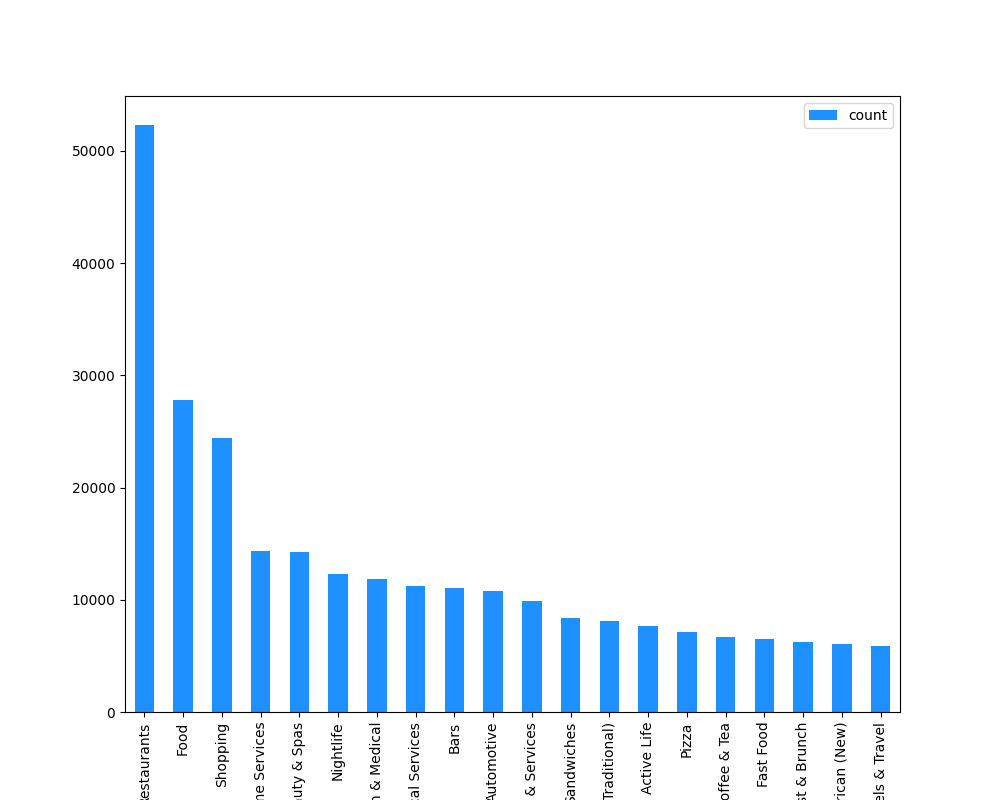

In [137]:
top_20 = comp_sort.limit(20).toPandas()
plt.figure(figsize =(10,8))
plt.title("Top 20 Categories on Yelp")
top_20.plot(kind='bar', x='category', color="dodgerblue", figsize=(10,8))
%matplot plt

## Part III: Do Yelp Reviews Skew Negative?
***

#### User Reviews Dataset 
***
*Note: I chose to upload all datasets at the beginning of the Notebook.*  
*See section titled "Loading Datasets from S3*"

The Review dataset schema is displayed below, followed by the first five rows of selected columns. 

In [14]:
review.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)

In [15]:
stars = review.select("business_id", "stars")
stars.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|         business_id|stars|
+--------------------+-----+
|XQfwVwDr-v0ZS3_Cb...|  3.0|
|7ATYjTIgM3jUlt4UM...|  5.0|
|YjUWPpI6HXG530lwP...|  3.0|
|kxX2SOes4o-D3ZQBk...|  5.0|
|e4Vwtrqf-wpJfwesg...|  4.0|
+--------------------+-----+
only showing top 5 rows

### Average Stars per Business
***

In [16]:
nll = '\\N'
avg_stars = review.select("business_id", "stars", "review_id", "user_id") \
    .filter((review.user_id != nll)) \
    .groupBy("business_id") \
    .agg(mean("stars").alias("avg_stars"))
avg_stars.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------------+
|         business_id|         avg_stars|
+--------------------+------------------+
|zJErbOQMKX-MwHs_u...|2.9279279279279278|
|RZ-FNTXvqHKngyLGD...|2.8823529411764706|
|HSzSGdcNaU7heQe0N...|3.3333333333333335|
|skW4boArIApRw9DXK...|2.3947368421052633|
|I0053JmJ5DEFUWSJ8...|2.3956043956043955|
+--------------------+------------------+
only showing top 5 rows

### Joined Datasets 
***

In [17]:
biz = business.select("business_id", "name", "city", "state", "stars")
merged = biz.join(avg_stars,["business_id"])
merged = merged.select("name", "city", "state", "stars", "avg_stars")
merged.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------+-----+-----+------------------+
|                name|        city|state|stars|         avg_stars|
+--------------------+------------+-----+-----+------------------+
|Gillane's Bar & G...|     Ardmore|   PA|  3.0|3.3333333333333335|
|Champps Penn's La...|Philadelphia|   PA|  2.5|2.3947368421052633|
|Philadelphia Marr...|Philadelphia|   PA|  3.0|2.9279279279279278|
|Golden Corral Buf...|      Tucson|   AZ|  2.5|2.3956043956043955|
|  Swiss Watch Center|       Tampa|   FL|  3.5| 3.357142857142857|
+--------------------+------------+-----+-----+------------------+
only showing top 5 rows

### Skew Calculation
***

In [38]:
skew1 = merged.withColumn('skew', ((col("avg_stars") - col("stars"))/ col("stars")))
skew1.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------+-----+-----+------------------+--------------------+
|                name|        city|state|stars|         avg_stars|                skew|
+--------------------+------------+-----+-----+------------------+--------------------+
|  Swiss Watch Center|       Tampa|   FL|  3.5| 3.357142857142857|-0.04081632653061223|
|Champps Penn's La...|Philadelphia|   PA|  2.5|2.3947368421052633|-0.04210526315789469|
|  NJ Weedman's Joint|     Trenton|   NJ|  4.0| 4.232558139534884|0.058139534883721034|
|Golden Corral Buf...|      Tucson|   AZ|  2.5|2.3956043956043955|-0.04175824175824179|
|Philadelphia Marr...|Philadelphia|   PA|  3.0|2.9279279279279278|-0.02402402402402...|
+--------------------+------------+-----+-----+------------------+--------------------+
only showing top 5 rows

### Skew Value Graph
***

#### Implications:
For this portion of the project, I decided to experiment with the number of bins used in a series of three histograms; the first histogram is plotted using 50 bins, the second with 75, and the third with 150. As the number of bins increases, it suggests that many of the reviews are quite close in value to the average rating of each business. Overall, however, there does appear to be a slightly negative skew to dataset. Implications are continued below.

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

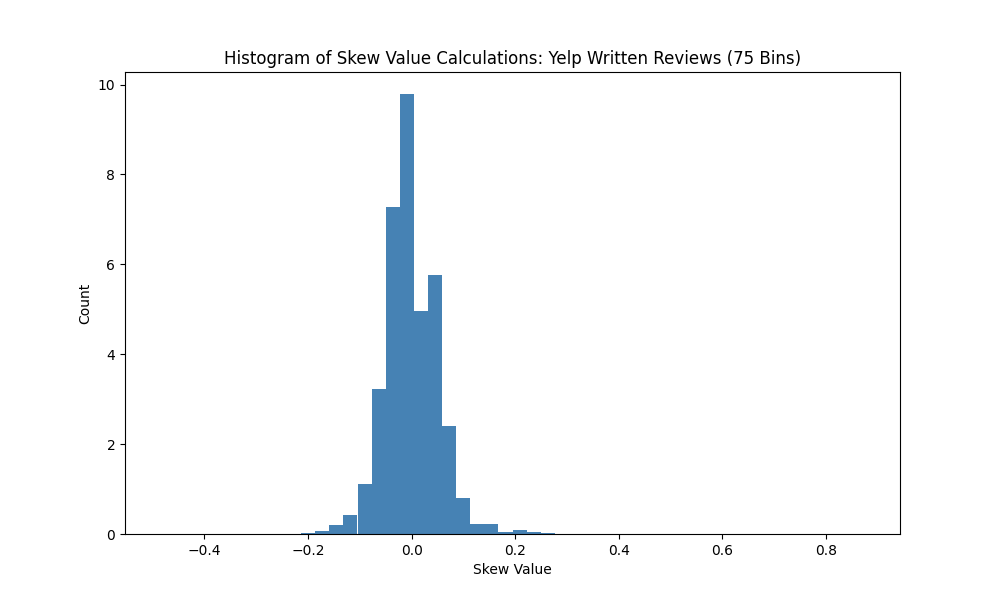

In [62]:
skew2 = skew1.toPandas()
plt.figure(figsize=(10,6))
plt.hist(skew2['skew'], density=True, bins=50, color="steelblue")
plt.xlabel("Skew Value")
plt.ylabel("Count")
plt.title("Histogram of Skew Value Calculations: Yelp Written Reviews (75 Bins)")
plt.show()
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

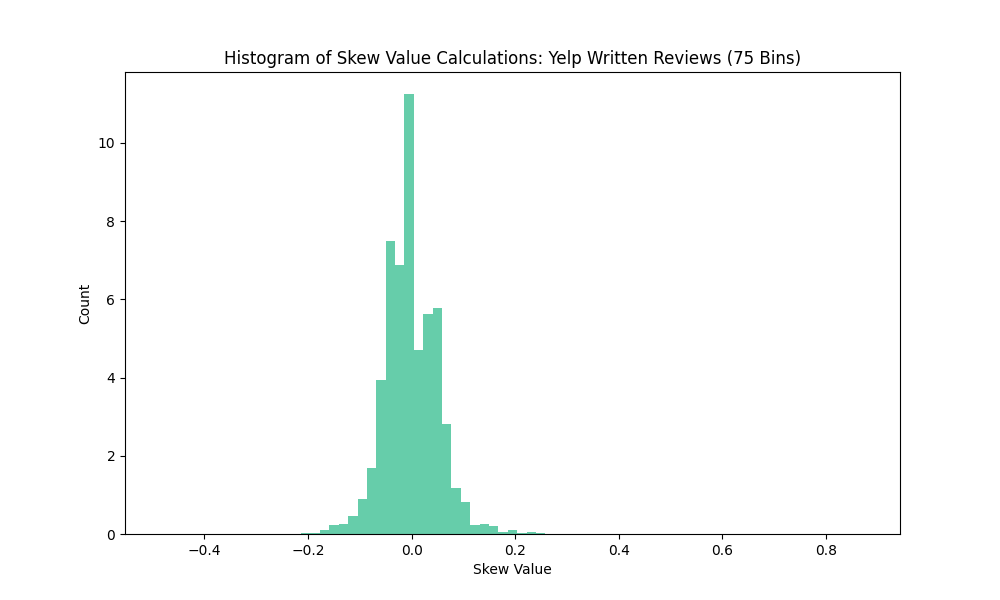

In [61]:
skew2 = skew1.toPandas()
plt.figure(figsize=(10,6))
plt.hist(skew2['skew'], density=True, bins=75, color="mediumaquamarine")
plt.xlabel("Skew Value")
plt.ylabel("Count")
plt.title("Histogram of Skew Value Calculations: Yelp Written Reviews (75 Bins)")
plt.show()
%matplot plt


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

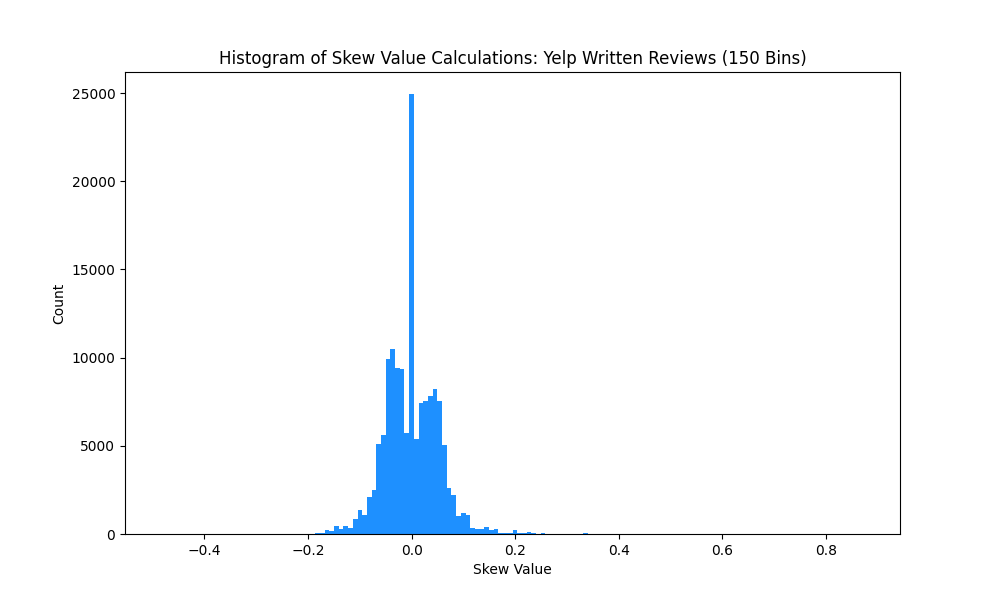

In [60]:
skew2 = skew1.toPandas()
plt.figure(figsize=(10,6))
plt.hist(skew2['skew'], bins=150, color="dodgerblue")
plt.xlabel("Skew Value")
plt.ylabel("Count")
plt.title("Histogram of Skew Value Calculations: Yelp Written Reviews (150 Bins)")
plt.show()
%matplot plt


#### Implications Continued:
***
The final histogram, with 150 bins, shows that nearly 25,000 reviews are identical to the mean review calculated in "average stars." At first, in the 50-bin histogram, it appears that the distribution of the data is unimodal, or nearly single-peaked. However, as we drill down and increase the number of bins in each successive visualization, the data looks increasingly multi-modal, with two clusters forming roughly equidistant from 0.0. It is possible that this is because customers are more likely to choose whole numbers (i.e. "3 stars" or "5 stars" rather than 3.5 or 4.5 stars) but this is just speculation. There does appear to be a slightly negative skew to the written Yelp reviews overall. 

## Part IV: Should the Elite be Trusted?
***

_"How accurate or close are the ratings of an "elite" user vs. the actual business ratings?"_

### Joining User and Review Datasets
***
First, I pulled up the schema of each dataset to determine which column to perform the join on:

In [67]:
user.printSchema()
review.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)

root
 |-- business_id: string (nullable = true)
 |-- cool: long (null

In [79]:
user1 = user.select("user_id", "elite","average_stars")\
    .filter((user.elite > 0))
review1 = review.select("user_id", "stars")\
    .withColumnRenamed("stars", "review_stars")
user_review = user1.join(review1,["user_id"])

user_review.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+-------------+------------+
|             user_id|elite|average_stars|review_stars|
+--------------------+-----+-------------+------------+
|yiYUEExKfZEv_T8CF...| 2015|         3.72|         3.0|
|yiYUEExKfZEv_T8CF...| 2015|         3.72|         4.0|
|yiYUEExKfZEv_T8CF...| 2015|         3.72|         3.0|
|yiYUEExKfZEv_T8CF...| 2015|         3.72|         4.0|
|yiYUEExKfZEv_T8CF...| 2015|         3.72|         3.0|
+--------------------+-----+-------------+------------+
only showing top 5 rows

### Comparing Elite User Ratings and Average Ratings
***
Using the method from Part 3, I calculated the "skew value" of an elite user's rating relative to the average (mean) rating on Yelp. The histogram of these results is below: 

In [80]:
user_skew = user_review.withColumn('elite_skew', ((col("average_stars") - col("review_stars"))/ col("review_stars")))
user_skew.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+-------------+------------+--------------------+
|             user_id|elite|average_stars|review_stars|          elite_skew|
+--------------------+-----+-------------+------------+--------------------+
|yiYUEExKfZEv_T8CF...| 2015|         3.72|         3.0| 0.24000000000000007|
|yiYUEExKfZEv_T8CF...| 2015|         3.72|         4.0|-0.06999999999999995|
|yiYUEExKfZEv_T8CF...| 2015|         3.72|         3.0| 0.24000000000000007|
|yiYUEExKfZEv_T8CF...| 2015|         3.72|         4.0|-0.06999999999999995|
|yiYUEExKfZEv_T8CF...| 2015|         3.72|         3.0| 0.24000000000000007|
+--------------------+-----+-------------+------------+--------------------+
only showing top 5 rows

In [81]:
elites1 = user_skew.select("elite_skew")
elites2 = elites1.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

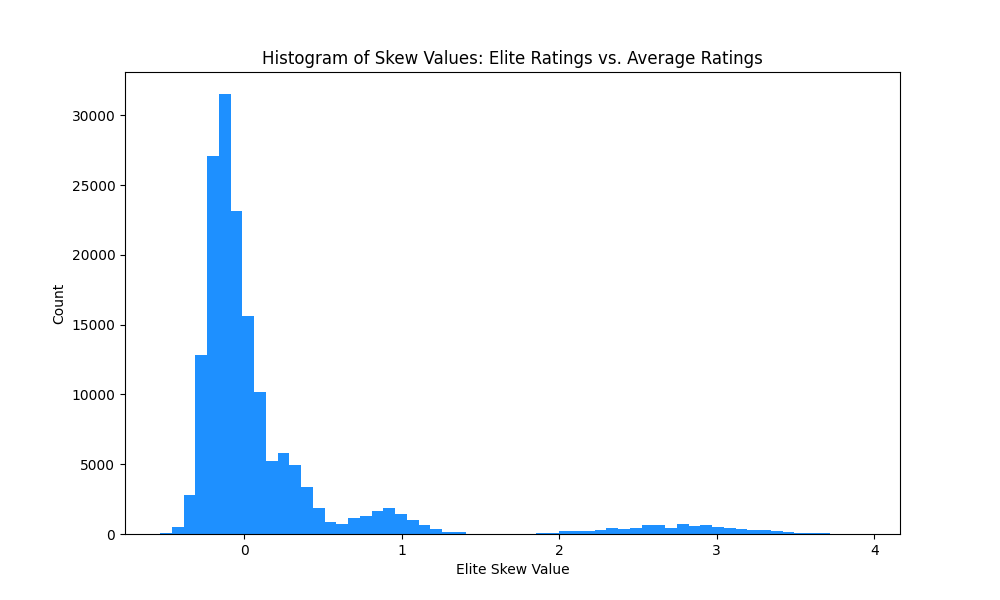

In [82]:
plt.figure(figsize=(10,6))
plt.hist(elites2['elite_skew'], bins=60, color="dodgerblue")
plt.xlabel("Elite Skew Value")
plt.ylabel("Count")
plt.title("Histogram of Skew Values: Elite Ratings vs. Average Ratings")
plt.show()
%matplot plt


In [94]:
elite_mean = elites1.agg({'elite_skew': 'mean'}).show()
elite_mean = elites1.agg({'elite_skew': 'stddev'}).show()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+
|   avg(elite_skew)|
+------------------+
|0.1607673546231813|
+------------------+

+------------------+
|stddev(elite_skew)|
+------------------+
|0.6831386838143271|
+------------------+

### Implications
***
The histogram's tail shows a strong positive skew to the right. After calculating the mean and the standard deviation above (using the .aggregate() function), it is clear that the mean value of 0.16 and the standard deviation value of 0.68 are quite far apart. This confirms what we can see in the histogram: that the data points have a high degree of variation. Additionally, the coefficent of variation can be approximated from these two figures: 0.68/0.16 = 4.25.  

This indicates that, while many elite Yelp reviewers give ratings that are quite close to the average Yelp rating (the mean value is 0.16 where a skew value of 0.0 would be a complete match with the average rating) there is considerable variability amongst elite users. A comparatively small but still significant number of elite ratings differ from the average by multiple standard deviations.  


## Extra Credit:
***
I decided to examine which states have the most active yelp users. This could be a valuable business insight for Yelp in determining where they choose to allocate resources and in identifying which markets they might wish to expand into.  

To achieve this, I first needed to join the review dataset with the business data set. (I will join user dataset in a later step.)

### US States with Greatest Market Penetration for Yelp
***

In [119]:
biz_ec = business.select("business_id", "name", "state", "stars")
rev_ec = review.select("business_id", "user_id")
temp_ec = biz_ec.join(rev_ec,["business_id"])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [111]:
temp2 = temp_ec.select("user_id", "state")
user_state = temp2.groupBy("state")\
    .agg(count("user_id").alias("count"))

Yelp_most_pop_states = user_state.sort(desc("count")) 

Yelp_most_pop_states.show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+-------+
|state|  count|
+-----+-------+
|   PA|1598960|
|   FL|1161545|
|   LA| 761673|
|   TN| 614388|
|   MO| 502385|
|   IN| 489752|
|   AZ| 431708|
|   NV| 430678|
|   CA| 348856|
|   NJ| 260897|
+-----+-------+
only showing top 10 rows

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

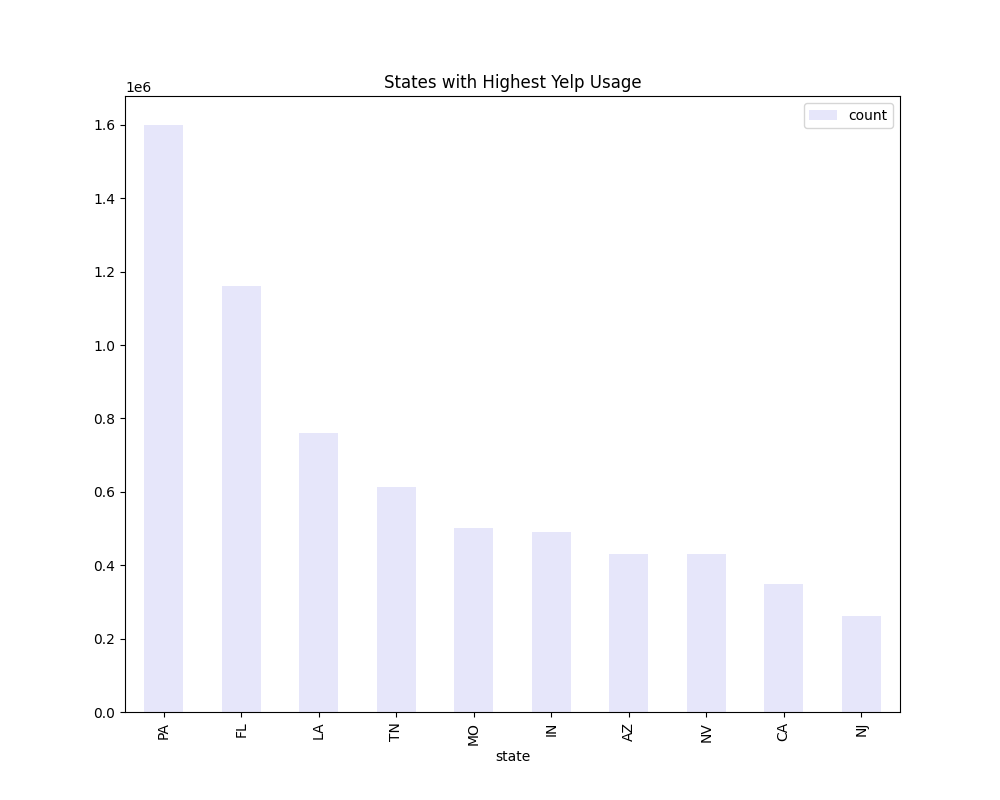

In [131]:
Yelp_Top_States = Yelp_most_pop_states.limit(10).toPandas()
plt.figure(figsize =(10,8))
Yelp_Top_States.plot(kind='bar', x='state', color="lavender", figsize=(10,8))
plt.title("States with Highest Yelp Usage")
%matplot plt

### States with Lowest Market Penetration:
***

In [104]:
Yelp_least_pop_states = user_state.sort(asc("count")) 
Yelp_least_pop_states.show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+-----+
|state|count|
+-----+-----+
|  XMS|    5|
|   MT|    6|
|   VT|   10|
|   MI|   11|
|   VI|   11|
|   WA|   19|
|   UT|   19|
|   NC|   29|
|   CO|   31|
|   HI|   34|
+-----+-----+
only showing top 10 rows

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

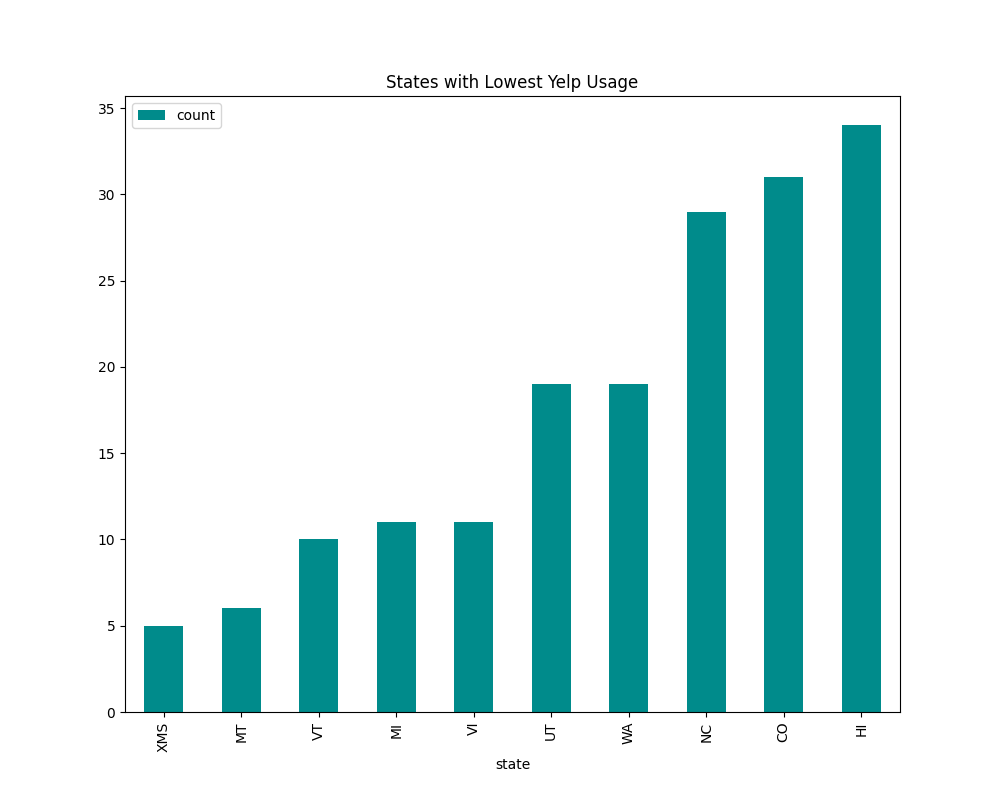

In [134]:
Yelp_Worst_States = Yelp_least_pop_states.limit(10).toPandas()
plt.figure(figsize =(10,8))
Yelp_Worst_States.plot(kind='bar', x='state', color="darkcyan", figsize=(10,8))
plt.title("States with Lowest Yelp Usage")
%matplot plt

### Joining the User and Business Datasets
***
Finally, I thought it would interesting to see the States that contained the most "elite" Yelp reviewers. In order to do this, I needed to join the User dataset to the Business dataset by linking each dataset to the Review dataset:

In [127]:
user_ec = user.select("user_id", "elite")\
    .filter((user.elite > 0))
user_business = temp2.join(user_ec,["user_id"])
elite_state = user_business.groupBy("state")\
    .agg(count("user_id").alias("elite_count"))

Elitist_States = elite_state.sort(desc("elite_count")) 
Elitist_States.show(10)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+-----------+
|state|elite_count|
+-----+-----------+
|   PA|      36266|
|   FL|      25232|
|   LA|      19113|
|   IN|      17751|
|   TN|      15358|
|   MO|      12817|
|   AZ|      10152|
|   NV|       8302|
|   CA|       6974|
|   NJ|       3838|
+-----+-----------+
only showing top 10 rows

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

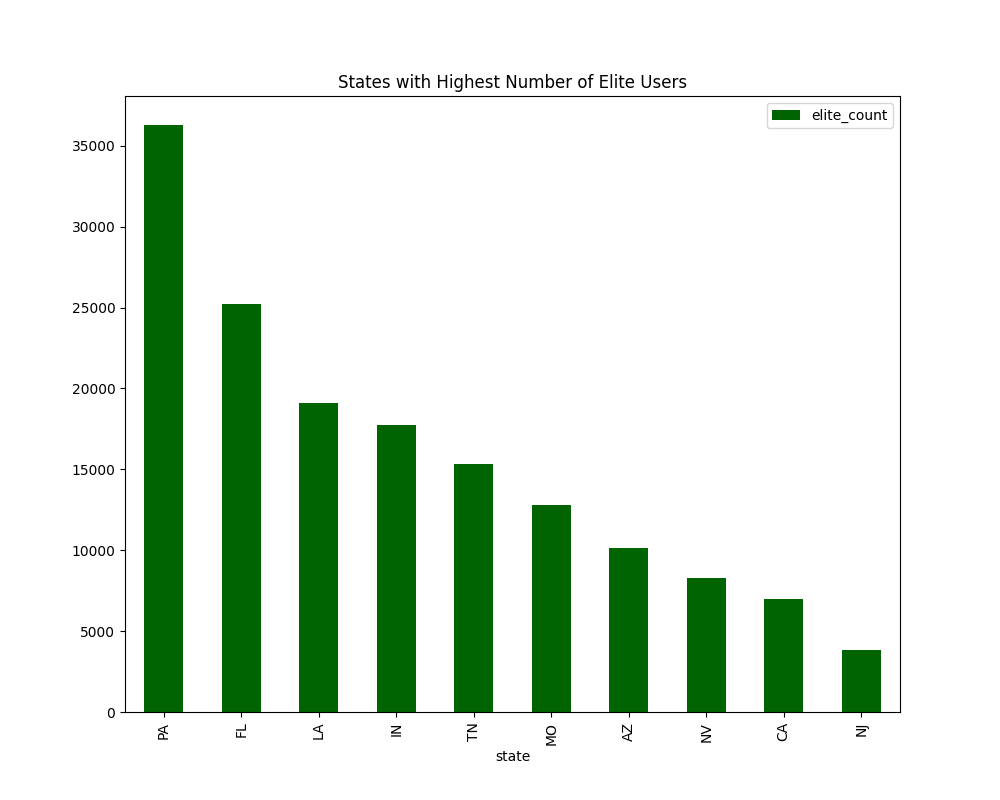

In [136]:
ElitistPanda = Elitist_States.limit(10).toPandas()
plt.figure(figsize =(10,8))
ElitistPanda.plot(kind='bar', x='state', color="darkgreen", figsize=(10,8))
plt.title("States with Highest Number of Elite Users")
%matplot plt